1. Для начала скачаем все нужные библиотеки.

In [3]:
import pandas as pd
import codecs
import nltk
import re
import os

from tqdm import tqdm

from nltk import word_tokenize
from nltk import sent_tokenize
from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import spacy
from spacy.tokens import Doc

import stanza
stanza.download("en")

from collections import Counter

import pickle
import json

from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt



2025-06-21 08:57:37 INFO: Downloaded file to C:\Users\Марина\stanza_resources\resources.json
2025-06-21 08:57:37 INFO: Downloading default packages for language: en (English) ...
2025-06-21 08:57:38 INFO: File exists: C:\Users\Марина\stanza_resources\en\default.zip
2025-06-21 08:57:42 INFO: Finished downloading models and saved to C:\Users\Марина\stanza_resources


2. Определим рабочую директорию и скорректируем ее.

In [4]:
print(os.getcwd())

c:\Users\Марина\OneDrive\Desktop\Компьютерная лингвистика\Python\Проект


In [5]:
os.chdir('c:/Users/Марина/OneDrive/Desktop/Компьютерная лингвистика/Python/Проект/корпус_текстов')

In [6]:
print(sorted(os.listdir()))

['A1', 'A1_lemmas.txt', 'A1_tokens.txt', 'A2', 'A2_lemmas.txt', 'A2_tokens.txt', 'B1', 'B1_lemmas.txt', 'B1_tokens.txt', 'B2', 'B2_lemmas.txt', 'B2_tokens.txt', 'C1', 'C1_lemmas.txt', 'C1_tokens.txt', 'analyzing_dependencies.json', 'bigrams_tokens.json', 'dependency_analysis.csv', 'dependency_analysis.xlsx', 'lemmatized.json', 'lemmatized.pkl', 'normalized_data.pkl', 'pos-tagged_lemmas.xlsx', 'pos_tags.xlsx', 'processed_data.json', 'processed_data.pkl', 'tf_idf.csv', 'tf_idf.xlsx']


3. Сбор корпуса по  5 уровням английского языка: A1, A2, B1, B2, C1.

In [7]:
# Создадим функцию, которая проходится по текстам в папке каждого уровня от A1 до C1 и собирает списки из текстов.

def texts_bylevels():
    path= os.getcwd()
    levels = ['A1', 'A2', 'B1', 'B2', 'C1']
    result = []

    for level in levels:
        folder_path = os.path.join(path, level)
        texts = []

        for file_name in sorted(os.listdir(folder_path)):
            full_path = os.path.join(folder_path, file_name)
            with open(full_path, 'r', encoding='utf-8') as file:
                    texts.append(file.read())

        result.append(texts)

    return result[0], result[1], result[2], result[3], result[4]

    
A1, A2, B1, B2, C1 = texts_bylevels()


In [16]:
# Создаем словарь для объединенных текстов

joined_texts = {
    'A1': "\n".join(A1),  
    'A2': "\n".join(A2),
    'B1': "\n".join(B1),
    'B2': "\n".join(B2),
    'C1': "\n".join(C1)
}


# И теперь извлекаем значения из словаря в отдельные переменные. В каждой переменной хранятся соединенные в один текст 40 текстов каждого уровня.

joined_A1 = joined_texts['A1']
joined_A2 = joined_texts['A2']
joined_B1 = joined_texts['B1']
joined_B2 = joined_texts['B2']
joined_C1 = joined_texts['C1']


4. Все этапы предобработки текста до уровня лемм соберем в одну удобную функцию с выводом двух результатов: 1) токены, 2) леммы.

In [50]:
# Создадим функцию обработки текстов для определения лемм

from stanza import DownloadMethod
nlp_stanza = stanza.Pipeline(lang = "en",
                             processors="tokenize, pos, lemma, ner, depparse", tokenize_pretokenized=True, tokenize_no_ssplit=True,
                             download_method=DownloadMethod.REUSE_RESOURCES, # чтобы сэкономить производительные силы компьютера
                             verbose = False) # убирает лишние логи


def normalize(text):
    
     # Воспользуемся spacy для удаления именованных сущностей из текста, пока он един (нам нужен контекст)  
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    # ИИ подсказал алгоритм, с помощью которого можно склеить токены текста после удаления именованных сущностей без больших пробелов
    # (особенно в словах с апострофом) без использования многочисленных регулярных выражений

    tokens = []
    spaces = []

    for token in doc:
        if not token.ent_type_: 
            tokens.append(token.text)
            spaces.append(bool(token.whitespace_))
    

     
    doc_cleaned = Doc(nlp.vocab, words=tokens, spaces=spaces)
    noent = doc_cleaned.text                                     # Получили текст без именованных сущностей


    # Следующим этапом с помощью RegexpTokenizer уберем пунктуацию и разделим слова на токены
    # Так как в тексте много слов с типографским апострофом " ’ ", заменим его на обычный " ' " для удобной чистки

    text_1 = noent.replace("’", "'")
    pattern = r"\w+(?:'\w+)?"
    tokenizer = RegexpTokenizer(pattern)

    tokenized_text = tokenizer.tokenize(text_1)

    # Почистим текст от стоп-слов (загрузим список стоп-слов и добавим к нему еще слова)

    stop_words = stopwords.words('english') + ['pm', 'mr', 'mrs', 'hi', 'wifi', 'oh']

    lower_tokens = [token.lower() for token in tokenized_text]    # Токены текста без именованных сущностей в нижнем регистре
    clean_tokens = []
    for word in lower_tokens:
        if word not in stop_words and word.isalpha():
            clean_tokens.append(word)
                
    if not clean_tokens:                             # Если после очистки токенов не осталось
        return{'tokens': [], 'lemmas': []}           # Возвращаем пустые списки
    
    # Наконец, получаем список лемм
    
    doc = nlp_stanza([clean_tokens])  
    lemmas = [word.lemma.lower() for sent in doc.sentences for word in sent.words]  
    
    return{'tokens': clean_tokens, 'lemmas' : lemmas}


In [21]:
# Обработаем все тексты функцией normalize, чтобы получить списки токенов и лемм для дальнейшей работы с ними, 
# а также сохраним их в формате pickle, чтобы потом оттуда выгружать данные и не тратить каждый раз производительные силы компьютера.

def normalizing_levels(joined_texts, output_file='normalized_data.pkl'):
    
    normalized_results = {} # Создаем словарь, куда будем выгружать результаты
    
    for level, text in tqdm(joined_texts.items()):
        normalized_results[level] = normalize(text)  
    
# Сохраняем в файл pickle

    with open(output_file, 'wb') as f:
        pickle.dump(normalized_results, f)
    
    print(f"{output_file}")
    return normalized_results


# Запустим обработку и сохранение

normalized_results = normalizing_levels(joined_texts)

100%|██████████| 5/5 [19:45<00:00, 237.11s/it]

normalized_data.pkl


In [47]:
# Создадим функцию, которая будет загружать сохраненные данные и возвращать отдельно токены и леммы

def load_and_extract(file_path='normalized_data.pkl'):
    
    with open(file_path, 'rb') as f: # так как pickle - бинарный формат данных (он быстрее обрабатывается), то сохраняем их в режиме rb
         data = pickle.load(f)
    
    
    # Извлекаем токены и леммы для каждого уровня

    tokens = {level: data[level]['tokens'] for level in data}
    lemmas = {level: data[level]['lemmas'] for level in data}
    
    return tokens, lemmas

5. Подсчет показателя TTR (type-token ratio), то есть коэффициента лексического разнообразия.

In [ ]:
# Создаём таблицу

df = pd.DataFrame([
    {
        'Level': level,
        'Total': len(normalized_data[level]['lemmas']),           # Подсчет общего количества лемм
        'Unique': len(set((normalized_data[level]['lemmas'])))    # Подсчет уникальных лемм
    }
    for level in ['A1', 'A2', 'B1', 'B2', 'C1']
])

# Вычислим показатель TTR
df['TTR'] = (df['Unique'] / df['Total'] * 100).round(1)           # Считаем показатель TTR: разделим общее количество лемм на количество уникальных лемм, округлим

print(df)

  Level  Total  Unique   TTR
0    A1   3667     853  23.3
1    A2   5361    1305  24.3
2    B1   6349    2001  31.5
3    B2   8950    2762  30.9
4    C1  10381    3324  32.0


Как видно из показателя, уровень лексического разнообразия растет с повышением уровня английского языка.

6. Синтаксический разбор.

In [ ]:
# Для анализа синтаксической сложности текстов каждого уровня будем использовать Stanza с названиями зависимостей в формате Universal Dependencies.

def analyzing_dependencies(doc):
        
    counters = {
               
        # Синтаксическая сложность
        'conj': 0,        # союзы (сложные предложения)
        'advcl': 0,       # обстоятельственные придаточные
        'acl': 0,         # определительные придаточные
        'ccomp': 0,       # дополнительные придаточные
        'xcomp': 0,       # открытые дополнения 
        
        # Морфология и времена
        'aux': 0,         # вспомогательные глаголы
        'auxpass': 0,     # пассивные конструкции
        'cop': 0,         # глаголы-связки (is, seem)
        'modals': 0,      # модальные глаголы (can, should)
        
        # Лексика
        'compound': 0,    # составные слова
                
        # Статистика
        'avg_sent_len': sum(len(s.words) for s in doc.sentences) / len(doc.sentences),  # средняя длина предложения
        'total_words': sum(len(s.words) for s in doc.sentences),                        # всего слов
        'unique_words': len({w.text.lower() for s in doc.sentences for w in s.words}),  # количество уникальных слов
    }
    
    # Подсчет зависимостей
    for sentence in doc.sentences:
        for word in sentence.words:
                           
            # Синтаксис
            if word.deprel == 'conj':
                counters['conj'] += 1
            elif word.deprel == 'advcl':
                counters['advcl'] += 1
            elif word.deprel == 'acl':
                counters['acl'] += 1
            elif word.deprel == 'ccomp':
                counters['ccomp'] += 1
            elif word.deprel == 'xcomp':
                counters['xcomp'] += 1
            
            
            # Глаголы и времена
            elif word.deprel == 'aux':
                counters['aux'] += 1
            elif word.deprel == 'auxpass':
                counters['auxpass'] += 1
            elif word.deprel == 'cop':
                counters['cop'] += 1
            elif word.upos == 'AUX' and word.text.lower() in {'can', 'could', 'may', 'might', 'must', 'shall', 'should', 'will', 'would'}:
                counters['modals'] += 1
            
            # Лексика
            elif word.deprel == 'compound':
                counters['compound'] += 1

    return counters



In [ ]:
# Пройдемся по текстам всех уровней и применим к ним функцию анализа зависимостей
results = {}
for level, text in tqdm(joined_texts.items()):
    doc = nlp_stanza(text)                        
    results[level] = analyzing_dependencies(doc)  

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [14:06<00:00, 169.39s/it]


In [ ]:
# Сохраним результаты анализа

with open('analyzing_dependencies.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)


In [ ]:
# Откроем результаты(при последующем открытии файла):

with open('analyzing_dependencies.json', 'r', encoding='utf-8') as f:
    loaded_results = json.load(f)

In [ ]:
# Оформим результаты в датафрейм

df_dependencies = pd.DataFrame.from_dict(results, orient='index')


# Добавим сортировку столбцов, чтобы было все нагляднее

column_order = [
    # Статистика
    'total_words', 'unique_words', 'avg_sent_len',
    
    # Синтаксическая сложность
    'conj', 'advcl', 'acl', 'ccomp', 'xcomp',
    
    # Морфология и времена
    'aux', 'auxpass', 'cop', 'modals',
    
    # Лексика
    'compound'
]
df_dependencies = df_dependencies[column_order]

# Посчитаем некоторые метрики

df_dependencies['lexical_diversity'] = df_dependencies['unique_words'] / df_dependencies['total_words']  # Лексическое разнообразие
df_dependencies['complexity_score'] = df_dependencies[['conj', 'advcl', 'acl', 'ccomp', 'xcomp']].sum(axis=1)  # Общий показатель сложности

# Сохраним в разных форматах на всякий случай
df_dependencies.to_csv('dependency_analysis.csv', float_format='%.2f')  
df_dependencies.to_excel('dependency_analysis.xlsx', float_format='%.2f') 

# Наконец, оформим результаты в красивую табличку

display(df_dependencies.style
       .background_gradient(cmap='Blues', subset=['complexity_score', 'lexical_diversity'])
       .format('{:.2f}', subset=pd.IndexSlice[:, df_dependencies.select_dtypes(include='number').columns]))



,total_words,unique_words,avg_sent_len,conj,advcl,acl,ccomp,xcomp,aux,auxpass,cop,modals,compound,lexical_diversity,complexity_score
A1,8593.00,2083.00,26.36,474.00,134.00,29.00,99.00,153.00,104.00,0.00,314.00,1.00,250.00,0.24,889.00
A2,12406.00,3110.00,31.17,577.00,318.00,67.00,221.00,274.00,311.00,0.00,342.00,2.00,343.00,0.25,1457.00
B1,14276.00,4067.00,46.65,691.00,342.00,148.00,123.00,256.00,336.00,0.00,325.00,2.00,755.00,0.28,1560.00
B2,17846.00,5255.00,58.13,838.00,530.00,222.00,202.00,379.00,487.00,0.00,411.00,1.00,773.00,0.29,2171.00
C1,22395.00,6304.00,39.71,964.00,554.00,251.00,281.00,391.00,605.00,0.00,516.00,2.00,854.00,0.28,2441.00


In [ ]:
# Посчитаем POS- теги и частотность 

# Анализ текста

data = []

for level, text in joined_texts.items():
    print(f'\nАнализ текста уровня {level}:')
    doc = nlp_stanza(text)
    pos_counts = Counter([word.upos for sentence in doc.sentences for word in sentence.words])

    print("Распределение частей речи:")
    for tag, count in pos_counts.items():
        print(f"{tag}: {count}")
        data.append([tag, count, level])



Анализ текста уровня A1:
Распределение частей речи:
PRON: 1010
AUX: 431
VERB: 1068
ADP: 828
ADJ: 688
NOUN: 1952
INTJ: 46
ADV: 421
NUM: 113
CCONJ: 398
DET: 869
SCONJ: 68
PUNCT: 140
PART: 156
PROPN: 399
SYM: 3
X: 3

Анализ текста уровня A2:
Распределение частей речи:
AUX: 696
PRON: 1385
NOUN: 2699
VERB: 1762
ADP: 1202
PART: 279
SCONJ: 227
CCONJ: 517
DET: 1057
ADJ: 760
ADV: 664
PUNCT: 214
PROPN: 670
NUM: 194
INTJ: 73
SYM: 3
X: 4

Анализ текста уровня B1:
Распределение частей речи:
ADJ: 1210
CCONJ: 596
NOUN: 3353
X: 6
SCONJ: 258
PRON: 1058
VERB: 1719
DET: 1445
AUX: 799
ADP: 1528
ADV: 664
PART: 319
PROPN: 924
NUM: 197
PUNCT: 153
INTJ: 46
SYM: 1

Анализ текста уровня B2:
Распределение частей речи:
NOUN: 4380
SCONJ: 484
DET: 1650
VERB: 2324
ADJ: 1601
ADP: 1892
AUX: 1092
PUNCT: 176
PART: 476
PRON: 1339
ADV: 926
CCONJ: 700
PROPN: 587
NUM: 181
INTJ: 37
SYM: 1

Анализ текста уровня C1:
Распределение частей речи:
ADJ: 1798
PROPN: 841
ADP: 2555
NUM: 316
DET: 2199
NOUN: 5179
ADV: 1330
AUX: 1377
PRO

In [132]:
# Оформим результаты в табличку

df_pos = pd.DataFrame(data, columns=['tag', 'count', 'level'])
df_pos


,tag,count,level
0,PRON,1010,A1
1,AUX,431,A1
2,VERB,1068,A1
3,ADP,828,A1
4,ADJ,688,A1
...,...,...,...
79,CCONJ,860,C1
80,PUNCT,250,C1
81,INTJ,46,C1
82,X,4,C1


In [ ]:
# И сохраним ее

df_pos.to_excel('pos_tags.xlsx', index=False)  

7. Подсчет и сравнение косинусных расстояний между текстами разных уровней английского языка.

In [ ]:
# Для подсчета косинусных расстояний создадим мешок слов для каждого уровня. 
# Для этого необходимо объединить леммы каждого уровня в одну строку.

# Загружаем сохранённые данные
with open('normalized_data.pkl', 'rb') as f:
    normalized_data = pickle.load(f)

# Соединяем леммы каждого уровня в одну строку
lemmas_by_level = {
    level: ' '.join(data['lemmas']) 
    for level, data in normalized_data.items()
}

# Подготовим данные для CountVectorizer

levels = list(lemmas_by_level.keys())
texts = list(lemmas_by_level.values())

In [ ]:
# Создаём модель мешка слов с помощью библиотеки sklearn

from sklearn.feature_extraction.text import CountVectorizer    # Импорт функции, которая создаст вектора мешка слов
vectorizer = CountVectorizer()                                 # Сохраним в переменную
X = vectorizer.fit_transform(texts)                            # Создадим модель мешка слов
len(vectorizer.get_feature_names_out())                        # Количество уникальных лемм в нашей модели

5393

In [ ]:
# Оформим результаты в табличку

text_vector = pd.DataFrame(columns = vectorizer.get_feature_names_out(), data = X.toarray())
text_vector

,abandon,abandonment,abdel,ability,abject,able,aboard,abroad,abruptly,absence,...,young,youth,youthful,youtube,zeppelin,zipped,zombie,zone,zoo,ºc
0,0,0,0,0,0,0,0,0,0,0,...,6,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,2,0,1,0,0,...,8,0,0,0,0,0,1,1,2,1
2,0,0,2,2,0,6,0,0,0,0,...,3,0,0,0,0,0,1,0,0,0
3,1,0,0,2,1,13,0,2,0,1,...,7,2,1,1,1,0,0,2,0,0
4,6,1,0,7,0,10,1,0,1,0,...,7,0,0,0,0,1,0,0,0,0


In [ ]:
# Создадим векторы

vector_1 = [X.toarray()[0]]
vector_2 = [X.toarray()[1]]
cosine_similarity(vector_1, vector_2)

array([[0.75070724]])

<Axes: >

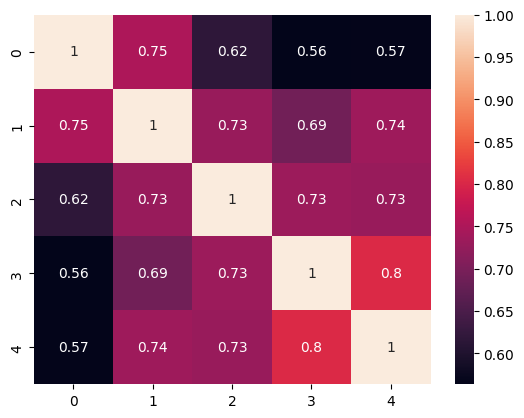

In [ ]:
# Нарисуем тепловой график с помощью seaborn для визуального представления данных

matrix_alt = cosine_similarity(X.toarray())
sns.heatmap(matrix, annot=True)

# 0- минимальная схожесть, 1- максимальная


Как видно из графика, самая минимальная схожесть с другими уровнями у уровня А1(0 на графике) - самого начального. Самая максимальная схожесть у уровней B2(3 на графике) и C1(4 на графике).

8. Посчитаем показатель tf-idf(term frequency-inverse document frequency).
Tf-idf помогает оценить важность слов в текстах. Высокий tf-idf показывает, что слово редко встречается в других уровнях. Если он нулевой - слово есть во всех уровнях и оно неинформативно.

In [38]:
# С помощью импортированного TfidfVectorizer получим вектора лемм в текстах

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1),  # (1,1) означает униграммы
                                   min_df=0.01,         # игнорирует слова, которые встречаются реже чем 1% текстов
                                   max_df=0.9,           # игнорирует слова, которые встречаются в >90% текстов
                                   token_pattern=r'\b[a-zA-Z]{3,}\b'  # Только слова из 3+ букв                                                 
                                   ) 

In [52]:
# Для более чистых результатов будем использовать списки лемм

tokens, lemmas = load_and_extract('normalized_data.pkl')

lemmatized_texts = {
    level: ' '.join(level_lemmas)               # Объединяем леммы через пробел
    for level, level_lemmas in lemmas.items()
}


In [54]:
# Преобразуем тексты в матрицу tf-idf

texts_for_tfidf = [
    lemmatized_texts['A1'],
    lemmatized_texts['A2'],
    lemmatized_texts['B1'],
    lemmatized_texts['B2'],
    lemmatized_texts['C1']
]

tfidf_matrix = tfidf_vectorizer.fit_transform(texts_for_tfidf)
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8432 stored elements and shape (5, 5012)>

In [55]:
# Преобразуем разреженную матрицу (хранит только ненулевые значения) в плотную (все значения явные)

npm_tfidf = tfidf_matrix.todense()

# Создадим словарь, в котором ключи - это уровни A1-C1, а значения - tf-idf вектора

document_vectors = {
    'A1': np.array(npm_tfidf[0]).flatten(),
    'A2': np.array(npm_tfidf[1]).flatten(),
    'B1': np.array(npm_tfidf[2]).flatten(),
    'B2': np.array(npm_tfidf[3]).flatten(),
    'C1': np.array(npm_tfidf[4]).flatten()
}

# Выводим список всех слов, которые учитывает векторизатор

print(tfidf_vectorizer.get_feature_names_out())

# Печатаем tf-idf вектора для каждого уровня

for level, vector in document_vectors.items():
    print(f"\nВектор TF-IDF для {level}:")
    print(vector) 


['abandon' 'abandonment' 'abdel' ... 'zombie' 'zone' 'zoo']

Вектор TF-IDF для A1:
[0.         0.         0.         ... 0.         0.         0.01543367]

Вектор TF-IDF для A2:
[0.         0.         0.         ... 0.01269144 0.01269144 0.02538288]

Вектор TF-IDF для B1:
[0.         0.         0.02460146 ... 0.00992415 0.         0.        ]

Вектор TF-IDF для B2:
[0.00642824 0.         0.         ... 0.         0.01285648 0.        ]

Вектор TF-IDF для C1:
[0.0368897  0.00762064 0.         ... 0.         0.         0.        ]


In [56]:
# Теперь преобразуем все вектора в списки для удобства

vectors_as_lists = {
    level: vector.tolist() 
    for level, vector in document_vectors.items()
}

In [57]:
# Создадим отдельные переменные для каждого уровня:

x_a1 = vectors_as_lists['A1']
x_a2 = vectors_as_lists['A2']
x_b1 = vectors_as_lists['B1']
x_b2 = vectors_as_lists['B2']
x_c1 = vectors_as_lists['C1']


In [58]:
# Оформим все в датафрейм

df_tfidf = pd.DataFrame.from_dict(vectors_as_lists, orient='index')
df_tfidf.columns = tfidf_vectorizer.get_feature_names_out()

In [59]:
df_tfidf

,abandon,abandonment,abdel,ability,abject,able,aboard,abroad,abruptly,absence,...,yolk,york,youth,youthful,youtube,zeppelin,zipped,zombie,zone,zoo
A1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.01913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015434
A2,0.000000,0.000000,0.000000,0.008862,0.000000,0.017725,0.000000,0.012691,0.000000,0.000000,...,0.031461,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012691,0.012691,0.025383
B1,0.000000,0.000000,0.024601,0.013860,0.000000,0.041580,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009924,0.000000,0.000000
B2,0.006428,0.000000,0.000000,0.008978,0.007968,0.058355,0.000000,0.012856,0.000000,0.007968,...,0.000000,0.00000,0.015935,0.007968,0.007968,0.007968,0.000000,0.000000,0.012856,0.000000
C1,0.036890,0.007621,0.000000,0.030053,0.000000,0.042933,0.007621,0.000000,0.007621,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.007621,0.000000,0.000000,0.000000


In [60]:
# Сохраним табличку в двух форматах

df_tfidf.to_csv('tf_idf.csv') 
df_tfidf.to_excel('tf_idf.xlsx', sheet_name='TF-IDF Results') 


In [ ]:
# Найдем топ-5 самых значимых слов для каждого уровня

top_words_per_level = {}
for level in df_tfidf.index:
    top_words = df_tfidf.loc[level].nlargest(5)  # Топ-5 слов
    top_words_per_level[level] = top_words
    print(f"{level}: {top_words.to_dict()}")

A1: {'forest': 0.23060407752580953, 'sister': 0.21779273988548678, 'bed': 0.2047687210067115, 'tree': 0.2047687210067115, 'cook': 0.18321411879547872}
A2: {'witch': 0.18876854479141278, 'phone': 0.17724817566084553, 'exam': 0.16498871280049376, 'woman': 0.1506609493117187, 'artist': 0.14749057686968264}
B1: {'include': 0.1524603642300034, 'photograph': 0.1290139666580671, 'robot': 0.11908981537667733, 'offer': 0.11781028145045717, 'professional': 0.11088026489454793}
B2: {'company': 0.17506428637212137, 'body': 0.1334004884549222, 'business': 0.12568717995947176, 'social': 0.12568717995947176, 'cannabis': 0.11951455903277367}
C1: {'paragraph': 0.19051598012540308, 'oil': 0.13269440315921727, 'however': 0.12880005597924843, 'human': 0.12880005597924843, 'feedback': 0.12296567454321418}
